# **Predicting Diamond Prices**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from numpy import mean , absolute, log1p, number
from scipy.stats.mstats import winsorize

In [ ]:
data = pd.read_csv('training.csv')

# Drop unwanted columns for this model
data = data.drop(columns=['LogRetail', 'Retail', 'id'])

For this dataset I will be using diamonds attributes to predict price.

## **Summary of Data**

In [ ]:
# Summarize the data. How much data is present? What attributes/features are continuous valued? Which attributes are categorical?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8050 entries, 0 to 8049
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Carats                  8050 non-null   float64
 1   Cert                    7498 non-null   object 
 2   Clarity                 8049 non-null   object 
 3   Color                   8050 non-null   object 
 4   Cut                     8050 non-null   object 
 5   Depth                   6610 non-null   float64
 6   Known_Conflict_Diamond  8050 non-null   bool   
 7   Measurements            8050 non-null   object 
 8   Polish                  8050 non-null   object 
 9   Regions                 8050 non-null   object 
 10  Shape                   8050 non-null   object 
 11  Symmetry                8050 non-null   object 
 12  Table                   5519 non-null   float64
 13  Vendor                  8050 non-null   int64  
 14  Price                   8050 non-null   

There are 8050 rows of data with 16 columns. (We notice some missing values)

**Continuous Valued:**
Carats, Depth, Table, Price, LogPrice


**Categorical Valued:**
Cert, Clarity, Color, Cut, Polish, Regions, Shape, Symmetry, Vendor, Known_Conflict_Diamond

## **EDA**

In [ ]:
# Display the statistical values for each of the attributes
data.describe()

,Carats,Depth,Table,Vendor,Price,LogPrice
count,8050.000000,6610.000000,5519.000000,8050.000000,8.050000e+03,8050.000000
mean,1.265807,61.723374,57.951984,2.050435,1.508101e+04,8.803274
std,0.894574,2.192793,3.051339,0.983876,3.564261e+04,1.225854
min,0.400000,0.000000,0.000000,1.000000,3.950000e+02,5.978886
25%,0.700000,61.000000,57.000000,1.000000,2.690000e+03,7.897296
50%,1.040000,62.000000,58.000000,2.000000,7.050000e+03,8.860783
75%,1.510000,62.600000,59.000000,3.000000,1.466000e+04,9.592878
max,11.920000,69.700000,69.000000,4.000000,1.087785e+06,13.899654


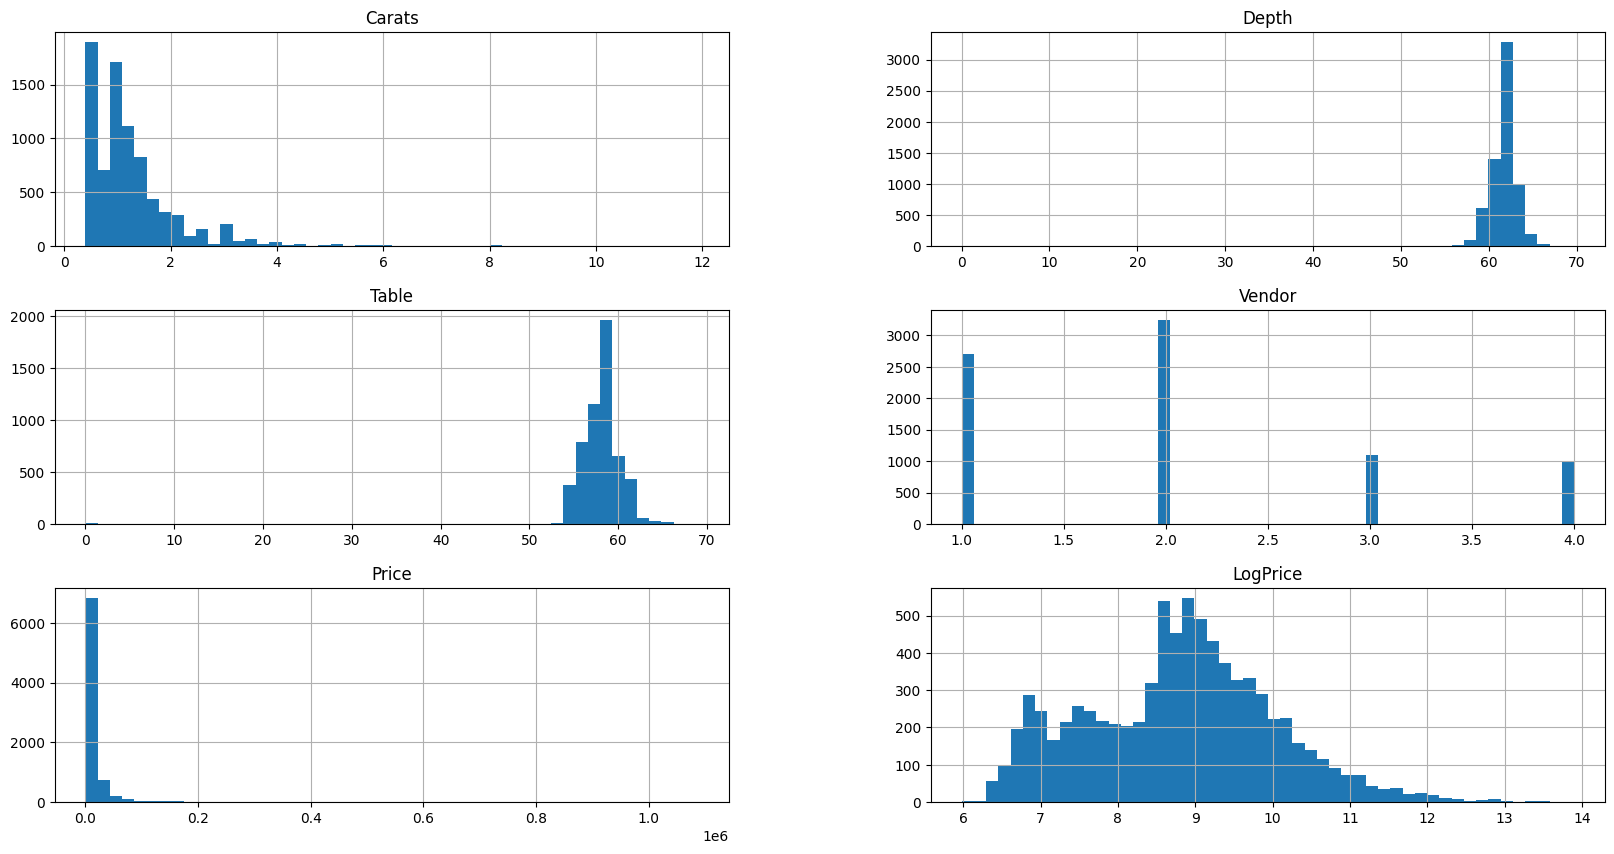

In [ ]:
# Display the visualizations (e.g., histogram) of the distributions for each attribute
%matplotlib inline
data.hist(bins=50, figsize=(20, 10))
plt.show()

Looking at the different distributions we see that **Carats**, **Depth**, and **Table** are all skewed with lower variance. We will want to adjust them and remove outliers. **Price** is also very skewed, but the log transformation is already provided thus we will not consider Price.

Remove Price

In [ ]:
# Remove Price
data = data.drop(columns=['Price'])

Missing Values

In [ ]:
print(data.isnull().sum())

missing_prop = data.isnull().sum() / len(data)
print("\nPercent Missing:")
print(missing_prop[missing_prop > 0].apply(lambda x: f"{x:.2%}"))


Carats                       0
Cert                       552
Clarity                      1
Color                        0
Cut                          0
Depth                     1440
Known_Conflict_Diamond       0
Measurements                 0
Polish                       0
Regions                      0
Shape                        0
Symmetry                     0
Table                     2531
Vendor                       0
LogPrice                     0
dtype: int64

Percent Missing:
Cert        6.86%
Clarity     0.01%
Depth      17.89%
Table      31.44%
dtype: object


Fix missing data

In [ ]:
# Drop Table column (over 30% missing)
data = data.drop(columns=['Table'])

# Drop Depth column (over 17% missing)
data = data.drop(columns=['Depth'])

# Use mode on Cert
data['Cert'] = data['Cert'].fillna(data['Cert'].mode()[0])

# Use Mode on Clarity
data['Clarity'] = data['Clarity'].fillna(data['Clarity'].mode()[0])

print(data.isnull().sum())

Carats                    0
Cert                      0
Clarity                   0
Color                     0
Cut                       0
Known_Conflict_Diamond    0
Measurements              0
Polish                    0
Regions                   0
Shape                     0
Symmetry                  0
Vendor                    0
LogPrice                  0
dtype: int64


Split Measurement

In [ ]:
# Split the "Measurements" column into three separate numeric columns
data[['Length', 'Width', 'Depth']] = data['Measurements'].str.split('x', expand=True).astype(float)


# Drop Measurements
data.drop(columns=['Measurements'], inplace=True)

Outliers

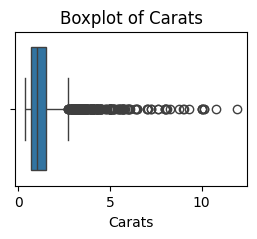

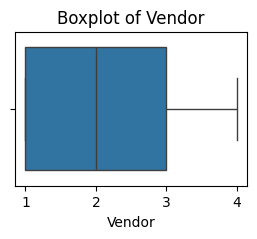

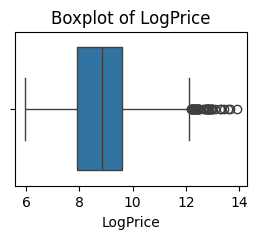

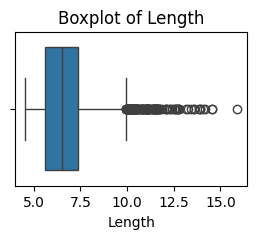

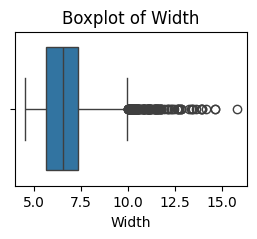

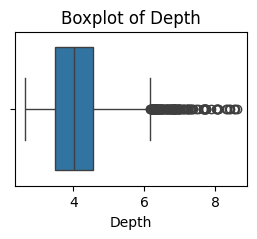

In [ ]:
# Boxplots
numeric_cols = data.select_dtypes(include=['number'])
for col in numeric_cols:
    plt.figure(figsize=(3, 2))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
# Carats using IQR
Q1 = data['Carats'].quantile(0.25)
Q3 = data['Carats'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data = data[(data['Carats'] >= lower_bound) & (data['Carats'] <= upper_bound)]

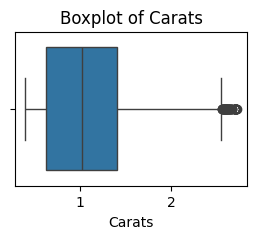

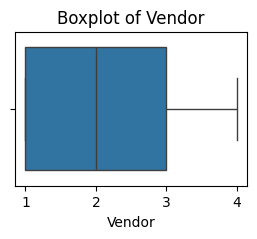

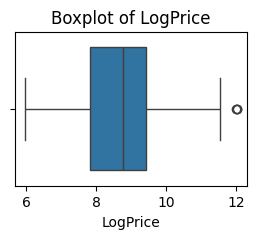

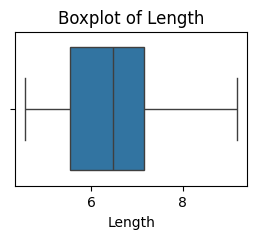

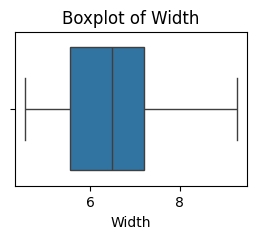

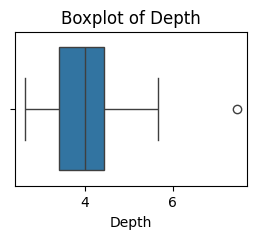

In [ ]:
# Boxplots
numeric_cols = data.select_dtypes(include=['number'])
for col in numeric_cols:
    plt.figure(figsize=(3, 2))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

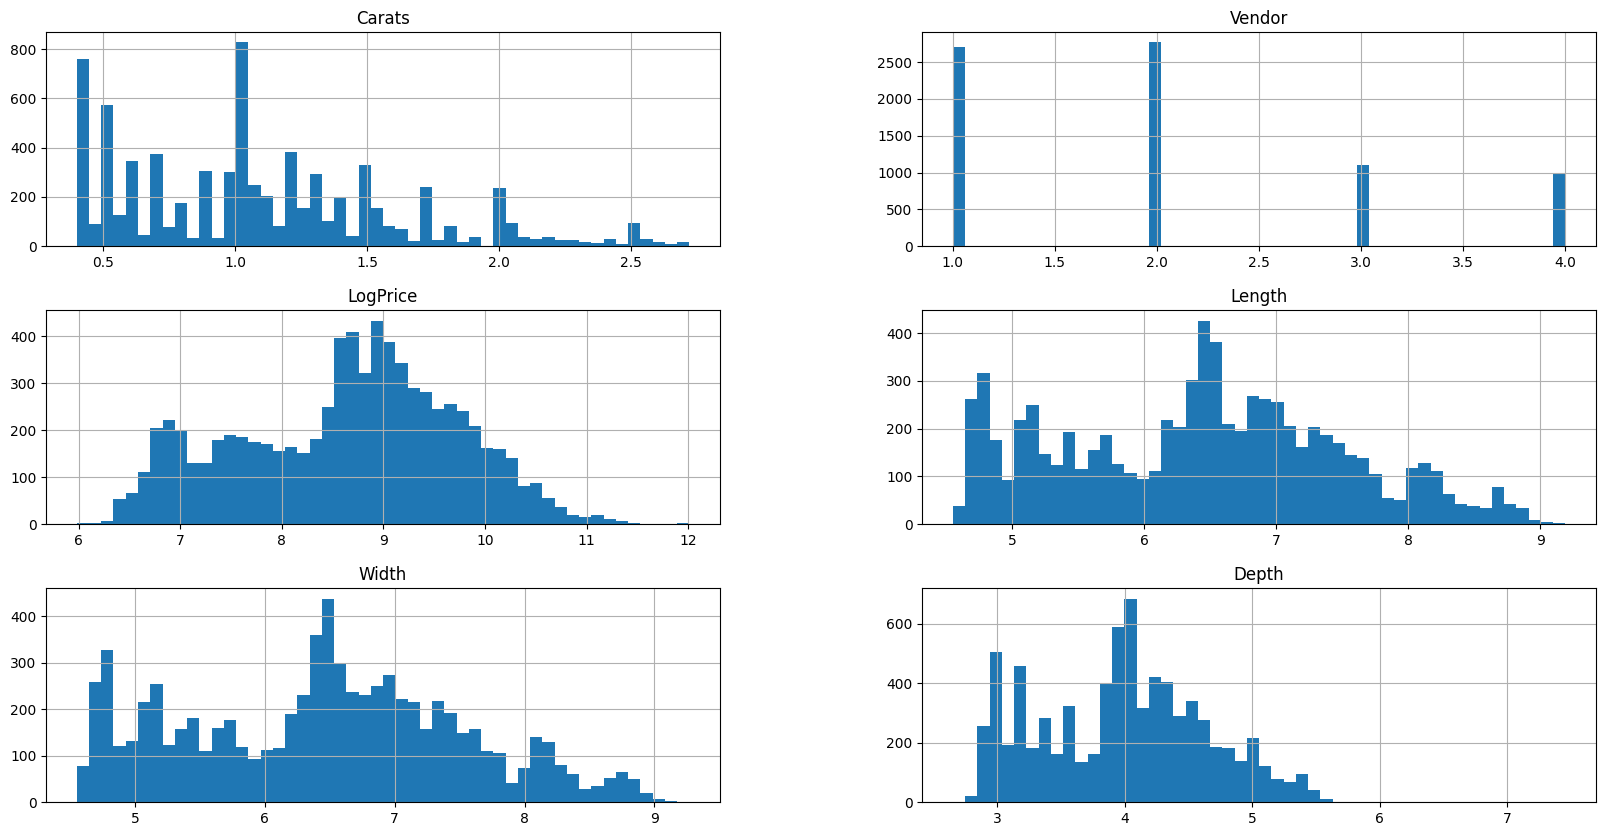

In [ ]:
# Display the visualizations (e.g., histogram) of the distributions for each attribute
%matplotlib inline
data.hist(bins=50, figsize=(20, 10))
plt.show()

Recheck data counts

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7558 entries, 0 to 8049
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Carats                  7558 non-null   float64
 1   Cert                    7558 non-null   object 
 2   Clarity                 7558 non-null   object 
 3   Color                   7558 non-null   object 
 4   Cut                     7558 non-null   object 
 5   Known_Conflict_Diamond  7558 non-null   bool   
 6   Polish                  7558 non-null   object 
 7   Regions                 7558 non-null   object 
 8   Shape                   7558 non-null   object 
 9   Symmetry                7558 non-null   object 
 10  Vendor                  7558 non-null   int64  
 11  LogPrice                7558 non-null   float64
 12  Length                  7558 non-null   float64
 13  Width                   7558 non-null   float64
 14  Depth                   7558 non-null   float

We still have 7558 rows from our orginal 8050 after removing outliers.

Frequency of Categortical Variables

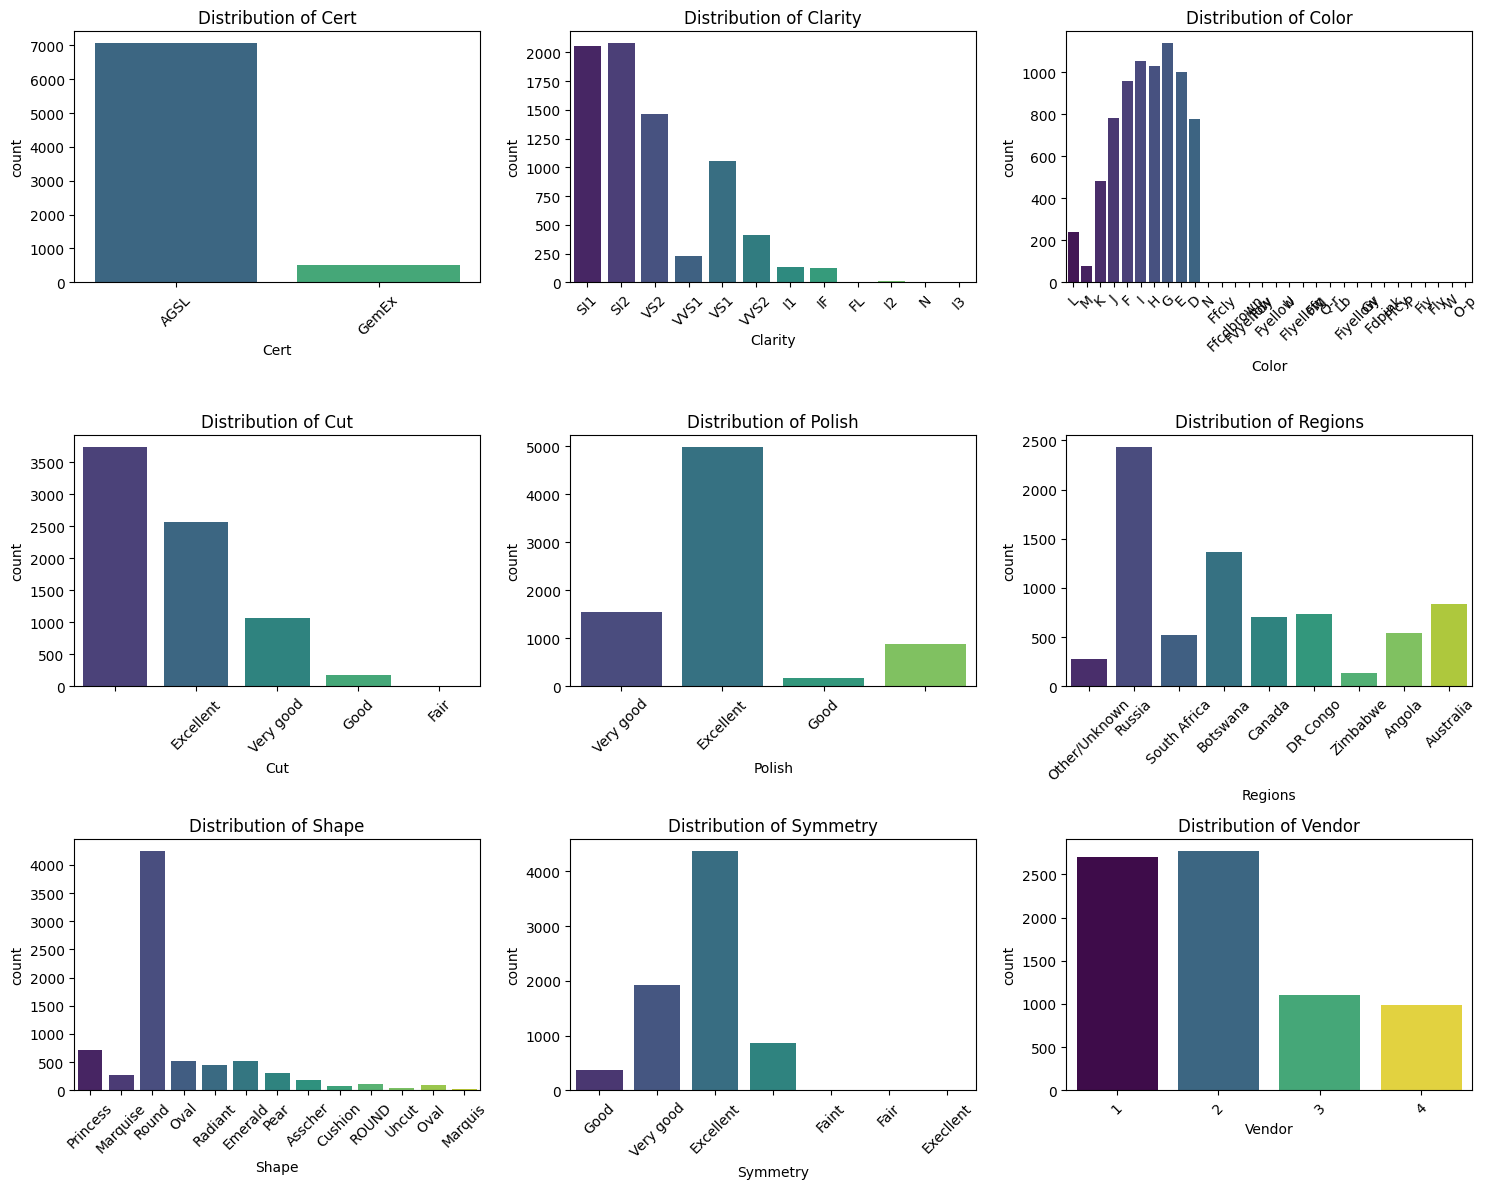

In [ ]:
categorical_columns = ['Cert', 'Clarity', 'Color', 'Cut', 'Polish', 'Regions', 'Shape', 'Symmetry', 'Vendor']

plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=data, x=col, hue=col, legend=False, palette="viridis")
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

From the distribution plot we see that we have many different color values. In order to keep compexity low we will not consider color.

In [ ]:
# Drop color
data = data.drop(columns=['Color'])

## **Analyze Relationships**

Encode Categorical Variables

In [ ]:
categorical_columns = ['Cert', 'Clarity', 'Cut', 'Polish', 'Regions', 'Shape', 'Symmetry', 'Vendor']

data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data.head(5)

,Carats,Known_Conflict_Diamond,LogPrice,Length,Width,Depth,Cert_GemEx,Clarity_I1,Clarity_I2,Clarity_I3,...,Shape_Uncut,Symmetry_Excellent,Symmetry_Execllent,Symmetry_Faint,Symmetry_Fair,Symmetry_Good,Symmetry_Very good,Vendor_2,Vendor_3,Vendor_4
0,0.41,False,6.063785,4.65,4.62,3.03,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.42,False,6.327937,4.85,4.79,2.98,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0.40,False,6.327937,4.66,4.63,2.97,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0.41,False,6.327937,4.71,4.69,2.95,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0.40,False,6.363028,4.71,4.68,2.96,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


Correlation Matrix

In [ ]:
corr_matrix = data.corr(numeric_only=True)
target_corr = corr_matrix['LogPrice'].sort_values(ascending=False)
print(target_corr)

LogPrice                  1.000000
Width                     0.941497
Length                    0.939687
Depth                     0.936319
Carats                    0.904475
Vendor_2                  0.409831
Cut_Excellent             0.360080
Vendor_4                  0.313620
Symmetry_Excellent        0.274181
Polish_Excellent          0.248953
Vendor_3                  0.180647
Clarity_IF                0.120341
Clarity_VS1               0.087716
Shape_Pear                0.030900
Clarity_VVS2              0.026977
Known_Conflict_Diamond    0.015507
Shape_Princess            0.014086
Regions_Other/Unknown     0.013071
Regions_Russia            0.012011
Clarity_VS2               0.010762
Shape_Emerald             0.008285
Regions_Canada            0.006937
Shape_Marquise            0.004956
Shape_Marquis             0.003132
Regions_Zimbabwe          0.002374
Regions_DR Congo          0.002270
Clarity_VVS1              0.001553
Symmetry_Execllent       -0.000033
Shape_Oval          

We see some attributes with good correlation like **Carats, Width, Length, Depth ,Cut, and Vendor**. But we also have some with very small correlation.

Plots

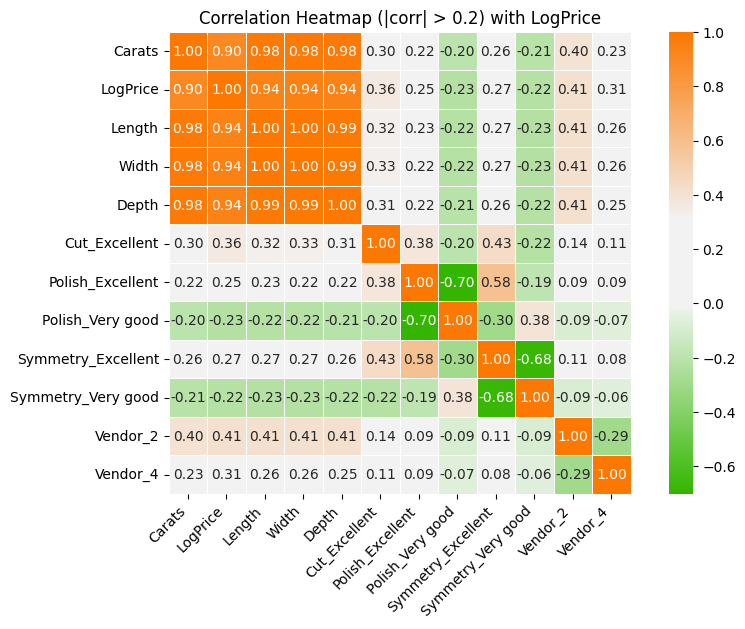

In [ ]:
# Set up colormap
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)

# Define threshold and filter correlations
threshold = 0.2
logprice_corr = corr_matrix['LogPrice']
filtered_corr = corr_matrix.loc[logprice_corr[logprice_corr.abs() >
                                              threshold].index, logprice_corr[logprice_corr.abs() >
                                                                              threshold].index]

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.heatmap(filtered_corr, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5, cbar=True, square=True)

# Adjust labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title("Correlation Heatmap (|corr| > 0.2) with LogPrice")
plt.show()


Overall we have numerous attributes with over a 0.2 correlation to **LogPrice**. **Carats** is our best predictor, and after splitting the **measurements** column each of those attributes are strongly correlated as well.



## **Split Data**

Split the data

In [ ]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

print(train_set.shape)
print(test_set.shape)

(6046, 54)
(1512, 54)


To verify that our test data is a representation of the entire data set we can compare mean and median values between the test and training set.

Mean

In [ ]:
# Display the size of each dataset
train_size = len(train_set)
test_size = len(test_set)
total_size = len(data)

# Compute percentage split
train_percent = (train_size / total_size) * 100
test_percent = (test_size / total_size) * 100

# Verify representativeness: Compare distributions of key features
feature_means_train = train_set.mean(numeric_only=True)
feature_means_test = test_set.mean(numeric_only=True)

print("Train Set Mean Values:")
print(feature_means_train)

print("\nTest Set Mean Values:")
print(feature_means_test)

print(f'\nDifference in means: \n{feature_means_train - feature_means_test}')

Train Set Mean Values:
Carats                    1.106727
Known_Conflict_Diamond    0.035726
LogPrice                  8.659790
Length                    6.448885
Width                     6.462698
Depth                     3.988204
Cert_GemEx                0.066325
Clarity_I1                0.016705
Clarity_I2                0.001819
Clarity_I3                0.000000
Clarity_IF                0.017532
Clarity_N                 0.000165
Clarity_SI1               0.268442
Clarity_SI2               0.276050
Clarity_VS1               0.141747
Clarity_VS2               0.193020
Clarity_VVS1              0.029110
Clarity_VVS2              0.055243
Cut_Excellent             0.340390
Cut_Fair                  0.001489
Cut_Good                  0.023817
Cut_Very good             0.144228
Polish_Excellent          0.656136
Polish_Good               0.023321
Polish_Very good          0.203936
Regions_Australia         0.111809
Regions_Botswana          0.176977
Regions_Canada            0.0959

Median

In [ ]:
# Display the size of each dataset
train_size = len(train_set)
test_size = len(test_set)
total_size = len(data)

# Compute percentage split
train_percent = (train_size / total_size) * 100
test_percent = (test_size / total_size) * 100

# Verify representativeness: Compare distributions of key features
feature_median_train = train_set.median(numeric_only=True)
feature_median_test = test_set.median(numeric_only=True)

print("Train Set Median Values:")
print(feature_median_train)

print("\nTest Set Median Values:")
print(feature_median_test)

print(f'\nDifference in means: \n{feature_median_train - feature_median_test}')

Train Set Median Values:
Carats                    1.020000
Known_Conflict_Diamond    0.000000
LogPrice                  8.775704
Length                    6.480000
Width                     6.500000
Depth                     4.010000
Cert_GemEx                0.000000
Clarity_I1                0.000000
Clarity_I2                0.000000
Clarity_I3                0.000000
Clarity_IF                0.000000
Clarity_N                 0.000000
Clarity_SI1               0.000000
Clarity_SI2               0.000000
Clarity_VS1               0.000000
Clarity_VS2               0.000000
Clarity_VVS1              0.000000
Clarity_VVS2              0.000000
Cut_Excellent             0.000000
Cut_Fair                  0.000000
Cut_Good                  0.000000
Cut_Very good             0.000000
Polish_Excellent          1.000000
Polish_Good               0.000000
Polish_Very good          0.000000
Regions_Australia         0.000000
Regions_Botswana          0.000000
Regions_Canada            0.00

We see that the the difference in mean and median between the training and test set is minimal for all attributes. Therefore we can conclude that the test portion of our data is representative of the entire data set.

Final Split & Scale the numeric data

In [ ]:
# Define features and target
target = "LogPrice"
X = data.drop(target, axis=1)
y = data[target]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify split shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6046, 53)
X_test shape: (1512, 53)
y_train shape: (6046,)
y_test shape: (1512,)


## **Linear Regression**

Linear Regression Model

In [ ]:
# Define cross-validation method to use
cv = KFold(n_splits=10, random_state=42, shuffle=True)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg.intercept_, lin_reg.coef_


# Use k-fold CV to evaluate model
scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

# Calculate and print the mean absolute error
print(mean(absolute(scores)))

0.2183431626418369


Test on some training instances

In [ ]:
# Select a few instances from the training set
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]

# Make predictions
some_predictions = lin_reg.predict(some_data)

# Print results
print("Predictions:", some_predictions)
print("Actual Labels:", list(some_labels))

Predictions: [7.50102883 9.51453998 7.61743047 8.73903058 8.4111924 ]
Actual Labels: [7.07326971745971, 9.09043007530363, 7.6425241342329, 8.71275997496021, 8.66388757056704]


**Four-fold cross-validation**

SVD

In [ ]:
# Predict on the entire training set
y_train_pred = lin_reg.predict(X_train)

# Compute RMSE
mse_train = mean_squared_error(y_train, y_train_pred)  # Calculate MSE
rmse_train = np.sqrt(mse_train)  # Convert MSE to RMSE

print("Linear Regression RMSE on Training Set:", rmse_train)

Linear Regression RMSE on Training Set: 0.28000350066294954


Plot

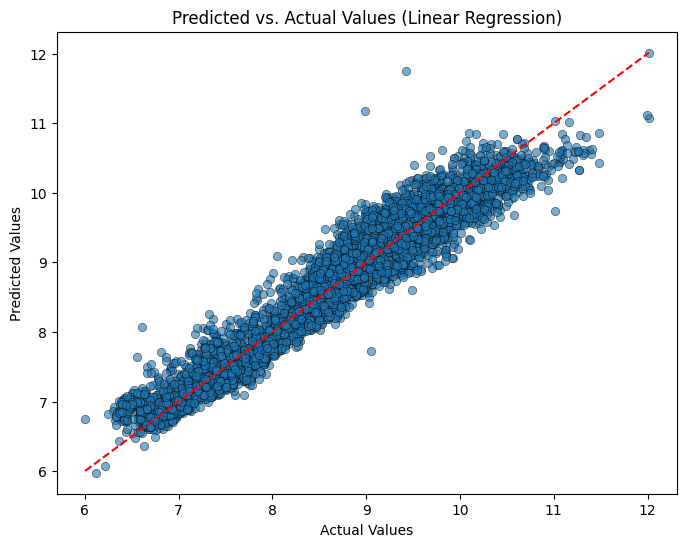

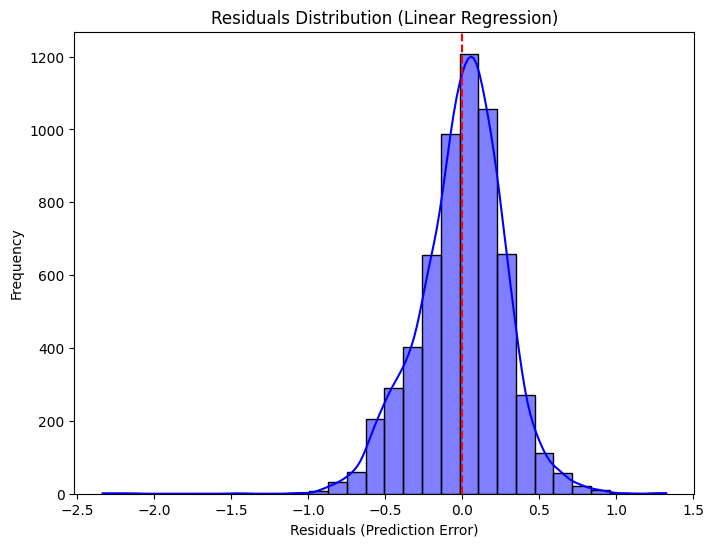

In [ ]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6, edgecolor="k")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle="--")  # Ideal fit line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values (Linear Regression)")
plt.show()

# Plot Residuals (Errors)
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(x=0, color="red", linestyle="--")
plt.xlabel("Residuals (Prediction Error)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (Linear Regression)")
plt.show()

Ridge Regresssion

In [ ]:
sdg_reg = SGDRegressor(penalty="l2", random_state=42, alpha=.0001, eta0=0.001)
sdg_reg.fit(X_train_scaled, y_train)

print("Ridge RMSE on Training Set:",
      np.sqrt(mean_squared_error(y_train, sdg_reg.predict(X_train_scaled))))

Ridge RMSE on Training Set: 0.2981636042931043


Change in Learning rates and Batch Size

In [ ]:
# Initialize SGDRegressor with desired learning rate
sgd_reg = SGDRegressor(penalty="l2", random_state=42, alpha=0.0001, eta0=0.001)

# Define batch size
batch_size = 32  # Adjust this value as needed

# Train in mini-batches using partial_fit
for epoch in range(100):
    for i in range(0, X_train_scaled.shape[0], batch_size):
        X_batch = X_train_scaled[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        sgd_reg.partial_fit(X_batch, y_batch)

    # Perform incremental learning
    sgd_reg.partial_fit(X_batch, y_batch)

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, sgd_reg.predict(X_train_scaled)))
print("RMSE on Training Set:", train_rmse)

RMSE on Training Set: 0.28918821842309234


Description:

This model applies Ridge Regression using Stochastic Gradient Descent (SGDRegressor) with L2 regularization to prevent overfitting. The first approach trains the model using batch gradient descent (fit) on the entire dataset, achieving a very low RMSE of 0.2981, suggesting strong convergence. The second approach optimizes learning by using mini-batch gradient descent (partial_fit) with a batch size of 32 and 100 epochs, allowing for incremental updates. The resulting RMSE of 0.2891 indicates that the model achieves nearly identical performance to full-batch training, confirming effective hyperparameter tuning. Further tuning of batch size, learning rate (eta0), and alpha could refine stability and generalization.

Lasso

In [ ]:
sdg_reg = SGDRegressor(penalty="l2", random_state=42, alpha= 0.0001, eta0=0.001)
sdg_reg.fit(X_train_scaled, y_train)

print("Lasso RMSE on Training Set:",
      np.sqrt(mean_squared_error(y_train, sdg_reg.predict(X_train_scaled))))

coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Weight": sdg_reg.coef_
})

print(coefficients)

Lasso RMSE on Training Set: 0.2981636042931043
                   Feature    Weight
0                   Carats  0.101356
1   Known_Conflict_Diamond  0.007598
2                   Length  0.249974
3                    Width  0.260511
4                    Depth  0.252682
5               Cert_GemEx -0.000486
6               Clarity_I1 -0.043135
7               Clarity_I2 -0.030521
8               Clarity_I3  0.000000
9               Clarity_IF  0.075111
10               Clarity_N -0.007873
11             Clarity_SI1 -0.022495
12             Clarity_SI2 -0.075822
13             Clarity_VS1  0.045459
14             Clarity_VS2  0.021096
15            Clarity_VVS1  0.031476
16            Clarity_VVS2  0.039257
17           Cut_Excellent  0.091967
18                Cut_Fair -0.007956
19                Cut_Good  0.019100
20           Cut_Very good  0.060047
21        Polish_Excellent  0.002640
22             Polish_Good -0.009939
23        Polish_Very good -0.018478
24       Regions_Australia  

Change in Learning rates and Batch Size

In [ ]:
# Initialize SGDRegressor with desired learning rate
sgd_reg = SGDRegressor(penalty="l1", random_state=42, alpha=0.0001, eta0=0.001)

# Define batch size
batch_size = 32  # Adjust this value as needed

# Train in mini-batches using partial_fit
for epoch in range(100):
    for i in range(0, X_train_scaled.shape[0], batch_size):
        X_batch = X_train_scaled[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        sgd_reg.partial_fit(X_batch, y_batch)

    # Perform incremental learning
    sgd_reg.partial_fit(X_batch, y_batch)

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, sgd_reg.predict(X_train_scaled)))
print("RMSE on Training Set:", train_rmse)

RMSE on Training Set: 0.2892145978224467


Description:

This model applies Lasso Regression using Stochastic Gradient Descent (SGDRegressor) with L1 regularization to enforce sparsity by shrinking some feature coefficients to zero. The first approach trains the model using batch gradient descent (fit), achieving a very low RMSE of 0.2892, indicating strong convergence. The second approach optimizes learning by implementing mini-batch gradient descent (partial_fit) with a batch size of 32 and 100 epochs, updating the model incrementally. The resulting RMSE remains 0.2892, suggesting that both training methods are converging to the same optimal solution. The displayed feature weights provide insights into which features are most important, with Lasso likely setting some coefficients to zero. Further tuning of alpha and batch_size could help optimize generalization and sparsity.

Elastic Net

In [ ]:
sdg_reg = SGDRegressor(penalty="elasticnet", random_state=42, alpha = 0.0001, eta0=0.001)
sdg_reg.fit(X_train_scaled, y_train)

print("Elastic Net RMSE on Training Set:",
      np.sqrt(mean_squared_error(y_train, sdg_reg.predict(X_train_scaled))))

Elastic Net RMSE on Training Set: 0.29816328780802964


Change in Learning rates and Batch Size

In [ ]:
# Initialize SGDRegressor with desired learning rate
sgd_reg = SGDRegressor(penalty="elasticnet", random_state=42, alpha=0.0001, eta0=0.001)

# Define batch size
batch_size = 32  # Adjust this value as needed

# Train in mini-batches using partial_fit
for epoch in range(100):
    for i in range(0, X_train_scaled.shape[0], batch_size):
        X_batch = X_train_scaled[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        sgd_reg.partial_fit(X_batch, y_batch)

    # Perform incremental learning
    sgd_reg.partial_fit(X_batch, y_batch)

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, sgd_reg.predict(X_train_scaled)))
print("RMSE on Training Set:", train_rmse)

RMSE on Training Set: 0.28919196907170075


Description:

This model applies Elastic Net Regression using Stochastic Gradient Descent (SGDRegressor), combining L1 (Lasso) and L2 (Ridge) regularization to balance feature selection and coefficient shrinkage. The first approach trains the model using batch gradient descent (fit), achieving an RMSE of 0.2982, indicating strong convergence. The second approach employs mini-batch gradient descent (partial_fit) with a batch size of 32 and 100 epochs, allowing incremental updates. The resulting RMSE of 0.2892 is nearly identical, confirming that both training methods converge effectively. Further tuning of alpha, l1_ratio, and batch size could optimize the trade-off between sparsity and generalization.

# **Polynomial Regression**

Polynomial Regression Model

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Fit model
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

# Make predictions
y_train_pred = lin_reg.predict(X_train_poly)

# Intercept and coefficient
lin_reg.intercept_, lin_reg.coef_

(-19.037346461570536,
 array([-13.44866955,   0.07034832,   6.15714425, ...,   0.16419969,
          0.        ,   1.63079642]))

**Four Fold Cross Validation**

SVD

In [ ]:
# Predict on the entire training set using the polynomial features
y_train_pred = lin_reg.predict(X_train_poly)

# Compute RMSE
mse_train = mean_squared_error(y_train, y_train_pred)  # Calculate MSE
rmse_train = np.sqrt(mse_train)  # Convert MSE to RMSE

print("Linear Regression RMSE on Training Set:", rmse_train)

Linear Regression RMSE on Training Set: 0.23701970047766077


Scale

In [ ]:
# Scale numeric features
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

Ridge Regression

In [ ]:
# Fit Ridge Regression using SGD
sgd_reg = SGDRegressor(penalty="l2", random_state=42, alpha=0.1, eta0=0.0001)
sgd_reg.fit(X_train_poly_scaled, y_train)

# Predict on the entire training set using polynomial features
y_train_pred = sgd_reg.predict(X_train_poly_scaled)

# Compute RMSE
mse_train = mean_squared_error(y_train, y_train_pred)  # Calculate MSE
rmse_train = np.sqrt(mse_train)  # Convert MSE to RMSE

# Print Results
print("Ridge Regression RMSE on Training Set:", rmse_train)

Ridge Regression RMSE on Training Set: 0.34466443856538864


Change in Learning rates and Batch Size

In [ ]:
# Initialize SGDRegressor with desired learning rate
sgd_reg = SGDRegressor(penalty="l2", random_state=42, alpha=0.1, eta0=0.0001)

# Define batch size
batch_size = 32  # Adjust this value as needed

# Train in mini-batches using partial_fit
for epoch in range(100):
    for i in range(0, X_train_poly_scaled.shape[0], batch_size):
        X_batch = X_train_poly_scaled[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        sgd_reg.partial_fit(X_batch, y_batch)

# Perform incremental learning
sgd_reg.partial_fit(X_batch, y_batch)

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, sgd_reg.predict(X_train_poly_scaled)))
print("RMSE on Training Set:", train_rmse)

RMSE on Training Set: 0.5574062678223624


**Description:**

This model applies Ridge Regression using Stochastic Gradient Descent (SGDRegressor) with polynomial features to capture non-linear relationships while preventing overfitting. The first approach trains the model on the entire dataset using batch gradient descent (fit), achieving a low RMSE of 0.3446, indicating strong convergence. The second approach optimizes training efficiency using mini-batch gradient descent (partial_fit) with a batch size of 32 over 100 epochs, resulting in a slightly higher RMSE of 0.5574. Before adjusting the alpha and learning rate the RMSE was extremly high, but now it converged.

Lasso

In [ ]:
# Fit Ridge Regression using SGD
sgd_reg = SGDRegressor(penalty="l1", random_state=42, alpha=0.1, eta0=0.0001)
sgd_reg.fit(X_train_poly_scaled, y_train)

# Predict on the entire training set using polynomial features
y_train_pred = sgd_reg.predict(X_train_poly_scaled)

# Compute RMSE
mse_train = mean_squared_error(y_train, y_train_pred)  # Calculate MSE
rmse_train = np.sqrt(mse_train)  # Convert MSE to RMSE

# Print Results
print("Lasso RMSE on Training Set:", rmse_train)

Lasso RMSE on Training Set: 0.44661691135406506


Change in Learning rates and Batch Size

In [ ]:
# Initialize SGDRegressor with desired learning rate
sgd_reg = SGDRegressor(penalty="l1", random_state=42, alpha=0.1, eta0=0.0001)

# Define batch size
batch_size = 32  # Adjust this value as needed

# Train in mini-batches using partial_fit
for epoch in range(100):
    for i in range(0, X_train_poly_scaled.shape[0], batch_size):
        X_batch = X_train_poly_scaled[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        sgd_reg.partial_fit(X_batch, y_batch)

# Perform incremental learning
sgd_reg.partial_fit(X_batch, y_batch)

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, sgd_reg.predict(X_train_poly_scaled)))
print("RMSE on Training Set:", train_rmse)

RMSE on Training Set: 0.6248836051922518


Description:

This model applies Lasso Regression using Stochastic Gradient Descent (SGDRegressor) with polynomial features, enforcing sparsity by shrinking some coefficients to zero. The first approach trains the model using batch gradient descent (fit), achieving an RMSE of 0.4524, indicating effective feature selection and regularization. The second approach uses mini-batch gradient descent (partial_fit) with a batch size of 32 over 100 epochs, resulting in a slightly higher RMSE of 0.6248, likely due to the increased variance in weight updates. The model employs alpha=0.1 for regularization and a small learning rate (eta0=0.0001) to ensure stability


Elastic Net

In [ ]:
# Fit Ridge Regression using SGD
sgd_reg = SGDRegressor(penalty="elasticnet", random_state=42, alpha=0.1, eta0=0.0001)
sgd_reg.fit(X_train_poly_scaled, y_train)

# Predict on the entire training set using polynomial features
y_train_pred = sgd_reg.predict(X_train_poly_scaled)

# Compute RMSE
mse_train = mean_squared_error(y_train, y_train_pred)  # Calculate MSE
rmse_train = np.sqrt(mse_train)  # Convert MSE to RMSE

# Print Results
print("Lasso RMSE on Training Set:", rmse_train)

Lasso RMSE on Training Set: 0.3751744885588683


Change in learning rates

In [ ]:
# Initialize SGDRegressor with desired learning rate
sgd_reg = SGDRegressor(penalty="elasticnet", random_state=42, alpha=0.1, eta0=0.0001)

# Define batch size
batch_size = 32  # Adjust this value as needed

# Train in mini-batches using partial_fit
for epoch in range(100):
    for i in range(0, X_train_poly_scaled.shape[0], batch_size):
        X_batch = X_train_poly_scaled[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        sgd_reg.partial_fit(X_batch, y_batch)

# Perform incremental learning
sgd_reg.partial_fit(X_batch, y_batch)

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, sgd_reg.predict(X_train_poly_scaled)))
print("RMSE on Training Set:", train_rmse)

RMSE on Training Set: 0.5735303886771154


This model applies Elastic Net Regression using Stochastic Gradient Descent (SGDRegressor) with polynomial features, combining L1 (Lasso) and L2 (Ridge) regularization to balance feature selection and coefficient shrinkage. The first approach trains the model using batch gradient descent (fit), achieving an RMSE of 0.3751, indicating strong convergence and an effective trade-off between sparsity and stability. The second approach uses mini-batch gradient descent (partial_fit) with a batch size of 32 over 100 epochs, leading to a slightly higher RMSE of 0.5735, suggesting that mini-batch updates introduce more variance in weight adjustments. The model employs alpha=0.1 to prevent overfitting and a small learning rate (eta0=0.0001) to ensure stability.

# **Predictions**

We will use the Linear Regression Ridge Model

In [ ]:
# Initialize Ridge Regression with SGD
sgd_reg = SGDRegressor(penalty="l2", random_state=42, alpha=0.0001, eta0=0.001, max_iter=1000, tol=1e-3)

# Train the model
sgd_reg.fit(X_train_scaled, y_train)

# Predict on Training Data
y_train_pred = sgd_reg.predict(X_train_scaled)


# Predict on Test Data
y_test_pred = sgd_reg.predict(X_test_scaled)

# Compute RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print Results
print("Ridge Regression RMSE on Training Set:", rmse_train)
print("Ridge Regression RMSE on Test Set:", rmse_test)

Ridge Regression RMSE on Training Set: 0.2981636042931043
Ridge Regression RMSE on Test Set: 0.291474319513308


Results:

Since the training and test RMSE are very close, the model is generalizing well and does not appear to be overfitting or underfitting. Overall, I am happy with the result, but the RMSE is a little deceving. Since this is the log price we have to convert it back to $ to understand how strong the model is. The Relative Error in Price Prediction: ±33.78%, which isn't great but not bad either, considering Diamonds in genral are high variance, even though I removed a lot of the outliers. I'm curious as to what grid search would do to the polynomial regression model. I believe optimizing the parameters could lead to a better result and reduce the error.